In [1]:
# N_TRAIN_ROW_TOTAL = 101230332
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False
    
if KAGGLE_RUN:
    model_name = 'modelloop2/modelloop2.txt'
else:
    model_name = 'modelloop2.txt'

import sys
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
#from tqdm.notebook import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt

if not KAGGLE_RUN:
    sys.path.insert(0, './input')
    import local_work
    
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()

import random
import os

In [2]:
# Funcion for user stats with loops
def add_features(df, answered_correctly_u_count
                 ,answered_correctly_u_sum, elapsed_time_u_sum
                 ,explanation_u_sum, timestamp_u
                 ,timestamp_u_incorrect, answered_correctly_q_count
                 ,answered_correctly_q_sum, elapsed_time_q_sum
                 ,explanation_q_sum, answered_correctly_uq
                 ,KAGGLE_RUN
                 ,is_inference):
    # -----------------------------------------------------------------------
    # Client features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    
    DF_NROW = df.shape[0]
    for num, row in enumerate(df[['user_id', 'answered_correctly'
                                  ,'content_id', 'prior_question_elapsed_time'
                                  ,'prior_question_had_explanation', 'timestamp']].values):
        
        if DF_NROW > 1000000 and not KAGGLE_RUN:
            if num % 500000 == 0:
                print(round(num/DF_NROW, 3))
                
        # Client features assignation
        # ------------------------------------------------------------------
        if answered_correctly_u_count[row[0]] != 0:
            answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            elapsed_time_u_avg[num] = elapsed_time_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        else:
            answered_correctly_u_avg[num] = np.nan
            elapsed_time_u_avg[num] = np.nan
            explanation_u_avg[num] = np.nan
            
        if len(timestamp_u[row[0]]) == 0:
            timestamp_u_recency_1[num] = np.nan
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 1:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 2:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 3:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][2]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_3[num] = row[5] - timestamp_u[row[0]][0]
        
        if len(timestamp_u_incorrect[row[0]]) == 0:
            timestamp_u_incorrect_recency[num] = np.nan
        else:
            timestamp_u_incorrect_recency[num] = row[5] - timestamp_u_incorrect[row[0]][0]
            
        # ------------------------------------------------------------------
        # Question features assignation
        if answered_correctly_q_count[row[2]] != 0:
            answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        else:
            answered_correctly_q_avg[num] = np.nan
            elapsed_time_q_avg[num] = np.nan
            explanation_q_avg[num] = np.nan
        # ------------------------------------------------------------------
        # Client Question assignation
        answered_correctly_uq_count[num] = answered_correctly_uq[row[0]][row[2]]
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # Client features updates
        answered_correctly_u_count[row[0]] += 1
        elapsed_time_u_sum[row[0]] += row[3]
        explanation_u_sum[row[0]] += int(row[4])
        if len(timestamp_u[row[0]]) == 3:
            timestamp_u[row[0]].pop(0)
            timestamp_u[row[0]].append(row[5])
        else:
            timestamp_u[row[0]].append(row[5])
        # ------------------------------------------------------------------
        # Question features updates
        answered_correctly_q_count[row[2]] += 1
        elapsed_time_q_sum[row[2]] += row[3]
        explanation_q_sum[row[2]] += int(row[4])
        # ------------------------------------------------------------------
        # Client Question updates
        answered_correctly_uq[row[0]][row[2]] += 1
        # ------------------------------------------------------------------
        # Flag for training and inference
        if not is_inference:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[5])
                else:
                    timestamp_u_incorrect[row[0]].append(row[5])
            
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
             
            
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg
                            , 'elapsed_time_u_avg': elapsed_time_u_avg
                            ,'explanation_u_avg': explanation_u_avg
                            ,'answered_correctly_q_avg': answered_correctly_q_avg
                            ,'elapsed_time_q_avg': elapsed_time_q_avg
                            ,'explanation_q_avg': explanation_q_avg
                            ,'answered_correctly_uq_count': answered_correctly_uq_count
                            ,'timestamp_u_recency_1': timestamp_u_recency_1
                            ,'timestamp_u_recency_2': timestamp_u_recency_2
                            ,'timestamp_u_recency_3': timestamp_u_recency_3
                            ,'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency})
    
    # Only need to concat rows if building a model or inferring
    if (not KAGGLE_RUN) or is_inference:
        df = pd.concat([df, user_df], axis = 1)
    return df
        
def update_features(df, answered_correctly_u_sum, answered_correctly_q_sum, timestamp_u_incorrect):
    for row in df[['user_id', 'answered_correctly', 'content_id', 'content_type_id', 'timestamp']].values:
        if row[3] == 0:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[4])
                else:
                    timestamp_u_incorrect[row[0]].append(row[4])
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
            
    return

def read_and_preprocess(KAGGLE_RUN):
    
    # Client dictionaries
    answered_correctly_u_count = defaultdict(int)
    answered_correctly_u_sum = defaultdict(int)
    elapsed_time_u_sum = defaultdict(int)
    explanation_u_sum = defaultdict(int)
    timestamp_u = defaultdict(list)
    timestamp_u_incorrect = defaultdict(list)
    
    # Question dictionaries
    answered_correctly_q_count = defaultdict(int)
    answered_correctly_q_sum = defaultdict(int)
    elapsed_time_q_sum = defaultdict(int)
    explanation_q_sum = defaultdict(int)
    
    # Client Question dictionary
    answered_correctly_uq = defaultdict(lambda: defaultdict(int))
    
    # Load questions
    if not KAGGLE_RUN:
        questions_df = local_work.get_questions_data()
    else:   
        questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
        
    # Change questions dtypes
    questions_df['part'] = questions_df['part'].astype(np.int32)
    questions_df['bundle_id'] = questions_df['bundle_id'].astype(np.int32)
        
    # Need to load all columns when batching
    train_cols = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
               'task_container_id', 'user_answer', 'answered_correctly',
               'prior_question_elapsed_time', 'prior_question_had_explanation']
    
    # Columns we need
    feld_needed = ['timestamp'
                   ,'user_id'
                   ,'answered_correctly'
                   ,'content_id'
                   ,'content_type_id'
                   ,'prior_question_elapsed_time'
                   ,'prior_question_had_explanation'
                  ]
    total_train_count = 0
    for i in range(11):
        if not KAGGLE_RUN:
            N_TRAIN_ROWS = 20 * 1000000
            train = local_work.get_train_data(feld_needed, nrow=N_TRAIN_ROWS)
            questions_df = local_work.get_questions_data()
        else:
            train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                            ,skip_to_line = i * 10000000 + 2
                            ,max_nrows=10000000).to_pandas()
            train.columns = train_cols
            train = train[feld_needed]
        
        total_train_count += train.shape[0]
    
        # Filter by content_type_id to discard lectures
        train = train.loc[train.content_type_id == 0].reset_index(drop = True)

        # No need for validation set if running on kaggle
        if not KAGGLE_RUN:
            # Make validation set
            # Add entire user histories to validation set
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.07 * tmp.shape[0]))
            valid_full = train.loc[train['user_id'].isin(tmp)]
            train.drop(valid_full.index, inplace=True)

            # Make validation the last 40 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_40 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(40)
            train.drop(valid_end_40.index, inplace=True)

            # Make validation set the last 100 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_100 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(100)
            train.drop(valid_end_100.index, inplace=True)   

            # Combine the sets
            print('Joining validation sets')
            valid = valid_full.append([valid_end_40, valid_end_100])
            print('Validation size: ' + str(valid.shape[0]))
            print('Train size: ' + str(train.shape[0]))
        else:
            valid = None

        # Changing dtype to avoid lightgbm error
        train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')

        # Merge with questions dataframe
        train = pd.merge(train, questions_df[['question_id', 'part']]
                         ,left_on = 'content_id'
                         ,right_on = 'question_id'
                         ,how = 'left')

        if not KAGGLE_RUN:
            valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')
            valid = pd.merge(valid, questions_df[['question_id', 'part']]
                             ,left_on = 'content_id'
                             ,right_on = 'question_id'
                             ,how = 'left')

        print('Train Feature Calculation Started - ' + str(i))
        train = add_features(train, answered_correctly_u_count
                             ,answered_correctly_u_sum, elapsed_time_u_sum
                             ,explanation_u_sum, timestamp_u
                             ,timestamp_u_incorrect, answered_correctly_q_count
                             ,answered_correctly_q_sum, elapsed_time_q_sum
                             ,explanation_q_sum, answered_correctly_uq
                             ,KAGGLE_RUN = KAGGLE_RUN
                             ,is_inference = False)
        
        # Only run once for model buildling
        if not KAGGLE_RUN:
            break
    
    print('Number of training rows read: ' + str(total_train_count))
    
    # Free up space
    if KAGGLE_RUN:
        del train
        train = None
    
    # Add features for validation set
    if not KAGGLE_RUN:
        print('Valid Feature Calculation Started')
        valid = add_features(valid, answered_correctly_u_count
                             ,answered_correctly_u_sum, elapsed_time_u_sum
                             ,explanation_u_sum, timestamp_u
                             ,timestamp_u_incorrect, answered_correctly_q_count
                             ,answered_correctly_q_sum, elapsed_time_q_sum
                             ,explanation_q_sum, answered_correctly_uq
                             ,KAGGLE_RUN = KAGGLE_RUN
                             ,is_inference = False)
    gc.collect()
    
    # Make feature_dicts dictionary for easy passing between functions
    features_dicts = {
        'answered_correctly_u_count': answered_correctly_u_count,
        'answered_correctly_u_sum': answered_correctly_u_sum,
        'elapsed_time_u_sum': elapsed_time_u_sum,
        'explanation_u_sum': explanation_u_sum,
        'answered_correctly_q_count': answered_correctly_q_count,
        'answered_correctly_q_sum': answered_correctly_q_sum,
        'elapsed_time_q_sum': elapsed_time_q_sum,
        'explanation_q_sum': explanation_q_sum,
        'answered_correctly_uq': answered_correctly_uq,
        'timestamp_u': timestamp_u,
        'timestamp_u_incorrect': timestamp_u_incorrect
    }
    
    return train, valid, questions_df, features_dicts

# Function for training and evaluation
def train_and_evaluate(train, valid, KAGGLE_RUN, model_name):
    
    TARGET = 'answered_correctly'
    FEATURES = ['prior_question_elapsed_time', 'prior_question_had_explanation'
                ,'part', 'answered_correctly_u_avg'
                ,'elapsed_time_u_avg', 'explanation_u_avg'
                ,'answered_correctly_q_avg', 'elapsed_time_q_avg'
                ,'explanation_q_avg', 'answered_correctly_uq_count'
                ,'timestamp_u_recency_1', 'timestamp_u_recency_2', 'timestamp_u_recency_3'
                ,'timestamp_u_incorrect_recency']
    
    if not KAGGLE_RUN:
        print(f'Traning with {train.shape[0]} rows and {len(FEATURES)} features')    
        d_train = lgb.Dataset(train[FEATURES], label=train[TARGET])
        d_valid = lgb.Dataset(valid[FEATURES], label=valid[TARGET])

        params = {'objective': 'binary', 
                  'seed': 0,
                  'metric': 'auc',
                  'learning_rate': .1,
                  'num_leaves': 120,
                  'feature_fraction': .8,
                  'bagging_fraction': .8,
                  'bagging_fraction': 0.80
                 }

        if True:
            model = lgb.train(
                            params = params,
                            train_set = d_train,
                            num_boost_round = 10000,
                            valid_sets = [d_train, d_valid],
                            early_stopping_rounds = 20,
                            verbose_eval = 50
                            )
            model.save_model(f'./output/' + model_name)
            lgb.plot_importance(model, importance_type='gain')
            lgb.plot_importance(model, importance_type='split')
        else:
            model = lgb.Booster(model_file='./output/' + model_name)
            lgb.plot_importance(model, importance_type='gain')
    else:
        model = lgb.Booster(model_file='/kaggle/input/' + model_name)

    return TARGET, FEATURES, model

# Using time series api that simulates production predictions
def inference(TARGET, FEATURES, model, questions_df, features_dicts):
    
    # Get feature dict
    answered_correctly_u_count = features_dicts['answered_correctly_u_count']
    answered_correctly_u_sum = features_dicts['answered_correctly_u_sum']
    elapsed_time_u_sum = features_dicts['elapsed_time_u_sum']
    explanation_u_sum = features_dicts['explanation_u_sum']
    answered_correctly_q_count = features_dicts['answered_correctly_q_count']
    answered_correctly_q_sum = features_dicts['answered_correctly_q_sum']
    elapsed_time_q_sum = features_dicts['elapsed_time_q_sum']
    explanation_q_sum = features_dicts['explanation_q_sum']
    answered_correctly_uq = features_dicts['answered_correctly_uq']
    timestamp_u = features_dicts['timestamp_u']
    timestamp_u_incorrect = features_dicts['timestamp_u_incorrect']
    
    # Get api iterator and predictor
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict
    
    previous_test_df = None
    for (test_df, sample_prediction_df) in iter_test:
        if previous_test_df is not None:
            previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
            update_features(previous_test_df, answered_correctly_u_sum, answered_correctly_q_sum, timestamp_u_incorrect)
        previous_test_df = test_df.copy()
        test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
        test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
        test_df = pd.merge(test_df, questions_df[['question_id', 'part']]
                           ,left_on = 'content_id'
                           ,right_on = 'question_id'
                           ,how = 'left')
        test_df[TARGET] = 0
        test_df = add_features(test_df, answered_correctly_u_count
                               ,answered_correctly_u_sum, elapsed_time_u_sum
                               ,explanation_u_sum, timestamp_u
                               ,timestamp_u_incorrect, answered_correctly_q_count
                               ,answered_correctly_q_sum, elapsed_time_q_sum
                               ,explanation_q_sum, answered_correctly_uq
                               ,KAGGLE_RUN = KAGGLE_RUN
                               ,is_inference = True)
        test_df[TARGET] =  model.predict(test_df[FEATURES])
        set_predict(test_df[['row_id', TARGET]])
        
    print('Job Done')

In [3]:
train, valid, questions_df, features_dicts = read_and_preprocess(KAGGLE_RUN)

Joining validation sets
Validation size: 2125742
Train size: 17484381
Train Feature Calculation Started
0.0
0.029
0.057
0.086
0.114
0.143
0.172
0.2
0.229
0.257
0.286
0.315
0.343
0.372
0.4
0.429
0.458
0.486
0.515
0.543
0.572
0.601
0.629
0.658
0.686
0.715
0.744
0.772
0.801
0.829
0.858
0.887
0.915
0.944
0.972
Number of training rows read: 20000000
Valid Feature Calculation Started
0.0
0.235
0.47
0.706
0.941


Traning with 17484381 rows and 14 features
[LightGBM] [Info] Number of positive: 11573210, number of negative: 5911171
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.420421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 17484381, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.661917 -> initscore=0.671849
[LightGBM] [Info] Start training from score 0.671849
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.76651	valid_1's auc: 0.768806
[100]	training's auc: 0.769626	valid_1's auc: 0.771602
[150]	training's auc: 0.770713	valid_1's auc: 0.772443
[200]	training's auc: 0.771349	valid_1's auc: 0.772809
[250]	training's auc: 0.771942	valid_1's auc: 0.773127
[300]	training's auc: 0.772436	valid_1's auc: 0.773326
[

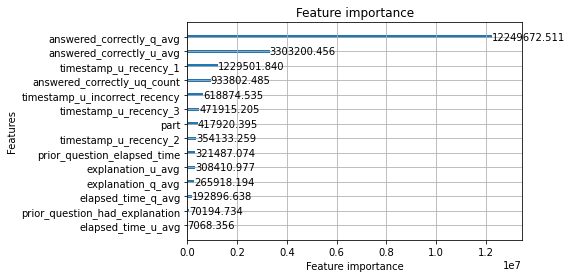

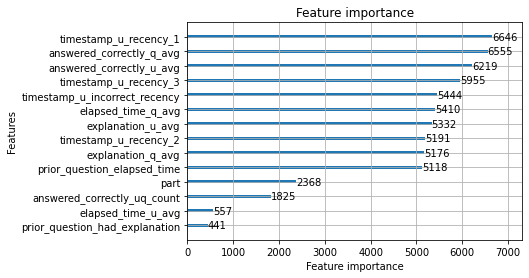

In [6]:
TARGET, FEATURES, model = train_and_evaluate(train, valid, KAGGLE_RUN, model_name)

In [7]:
inference(TARGET, FEATURES, model, questions_df, features_dicts)

Job Done
